Analysis Performed:
    
1. Initial Analysis
2. Dividing the Data into 3 groups based on Time spent
    - Group0 Analysis
    - Group1 Analysis
3. Anomaly detection
    - By out of Benhaviour pattern
    - By Weekly Average 

In [113]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import datetime

#anomaly detection
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import QuantileAD

In [114]:
data = pd.read_csv('Data/Engagements - ds_exercise.csv')

In [115]:
data.head()

,member_id,member_program_id,time_spent,service_date,care_extender_id,program_id
0,20220,20767,1.0,2020-01-01,88,29
1,20298,20854,10.0,2020-01-01,25,29
2,19981,20528,1.0,2020-01-01,88,29
3,19542,20033,1.0,2020-01-01,49,79
4,15999,16484,10.0,2020-01-01,126,10


In [116]:
print("The start date is {}".format(data['service_date'].min()))
print("The end date is {}".format(data['service_date'].max()))

The start date is 2020-01-01
The end date is 2020-06-26


In [117]:
# Assigning a new column that denotes the week no.
data['service_time'] = pd.to_datetime(data['service_date'], format='%Y-%m-%d')
data['week_no'] = data['service_time'].dt.week

## Dividing the data into three groups based on "time spent"

In [118]:
# Groupby time spent on the whole data per each member
member_wise = data.groupby('member_id')['time_spent'].agg('sum').reset_index().sort_values('time_spent', ascending=False)
member_wise.head()

,member_id,time_spent
8949,19981,6989.0
8948,19979,3614.0
7110,16707,3270.0
6839,16411,2920.0
9416,20816,2530.0


I have used pd.qcut to create groups. **qcut** tries to split the underlying data into bins of equal size.
The method determines the bins by using percentiles based on the data distribution, not the bins' actual numeric edges. However, the bins created for this particular data do not seem to of the same size and my assumption is that due to repeated values, bin sizes are not equal.

In [119]:
member_wise['time_spent'].describe()

count    14063.000000
mean       124.698784
std        200.828716
min          0.000000
25%         16.000000
50%         50.000000
75%        150.000000
max       6989.000000
Name: time_spent, dtype: float64

In [120]:
member_wise['group'] = pd.qcut(member_wise['time_spent'], 3, labels=[0, 1, 2]) 

In [121]:
print("Average, Mininum, and Maximum time spent by members that are in group 0: {} mins, {} mins, {} mins".format(round(member_wise[member_wise['group'] == 0]['time_spent'].mean(), 2), 
                                                                                                  member_wise[member_wise['group'] == 0]['time_spent'].min(), 
                                                                                                  member_wise[member_wise['group']==0]['time_spent'].max()))

print("Average, Mininum, and Maximum time spent by members that are in group 1: {} mins, {} mins, {} mins".format(round(member_wise[member_wise['group'] == 1]['time_spent'].mean(), 2), 
                                                                                                  member_wise[member_wise['group'] == 1]['time_spent'].min(), 
                                                                                                  member_wise[member_wise['group']==1]['time_spent'].max()))

print("Average, Mininum, and Maximum time spent by members that are in group 2: {} mins, {} mins, {} mins".format(round(member_wise[member_wise['group'] == 2]['time_spent'].mean(), 2), 
                                                                                                  member_wise[member_wise['group'] == 2]['time_spent'].min(), 
                                                                                                  member_wise[member_wise['group']==2]['time_spent'].max()))


Average, Mininum, and Maximum time spent by members that are in group 0: 11.44 mins, 0.0 mins, 22.0 mins
Average, Mininum, and Maximum time spent by members that are in group 1: 56.18 mins, 23.0 mins, 105.0 mins
Average, Mininum, and Maximum time spent by members that are in group 2: 309.18 mins, 106.0 mins, 6989.0 mins


### Group 0 Analysis

In [122]:
member_wise = member_wise.drop('time_spent', axis=1)

In [123]:
data = pd.merge(member_wise, data)
data.head()

,member_id,group,member_program_id,time_spent,service_date,care_extender_id,program_id,service_time,week_no
0,19981,2,20528,1.0,2020-01-01,88,29,2020-01-01,1
1,19981,2,20528,165.0,2020-01-02,88,29,2020-01-02,1
2,19981,2,20528,3.0,2020-01-05,88,29,2020-01-05,1
3,19981,2,20528,2.0,2020-01-06,88,29,2020-01-06,2
4,19981,2,20528,260.0,2020-01-06,49,29,2020-01-06,2


In [124]:
# Now that we have groups alloted in the main dataset. Let's analyze!
group_0 = data[data['group'] == 0]
group_1 = data[data['group'] == 1]
group_2 = data[data['group'] == 2]

#### Top 10 Programs have been taken the most by members in Group 0

In [125]:
group_0_programs = group_0.groupby('program_id')['member_id'].agg('count').reset_index().sort_values('member_id', ascending = False).head(10)
group_0_programs = group_0_programs.rename(columns = {'member_id': 'counts'})
group_0_programs

,program_id,counts
0,2,4959
1,10,2315
13,84,1065
19,97,749
6,55,696
8,79,544
4,48,538
2,26,377
7,77,344
22,101,264


#### Top 10 dates on which most service was received in Group 0

In [126]:
group_0_dates = group_0.groupby('service_date')['member_id'].agg('count').reset_index().sort_values('member_id', ascending = False).head(10)
group_0_dates = group_0_dates.rename(columns = {'member_id': 'counts'})
group_0_dates

,service_date,counts
1,2020-01-02,285
2,2020-01-03,279
141,2020-06-22,232
14,2020-01-15,232
8,2020-01-09,224
15,2020-01-16,211
9,2020-01-10,210
7,2020-01-08,201
5,2020-01-06,200
87,2020-04-15,188


#### Top 10 care extenders that provided service for members in Group 0

In [127]:
group_0_ce = group_0.groupby('care_extender_id')['member_id'].agg('count').reset_index().sort_values('member_id', ascending = False).head(10)
group_0_ce = group_0_ce.rename(columns = {'member_id': 'counts'})
group_0_ce

,care_extender_id,counts
45,132,5743
16,75,2050
25,93,1111
18,77,399
19,79,253
17,76,238
15,74,217
40,126,183
39,123,167
56,152,165


### Group 1 Analysis

#### Top 10 Programs have been taken the most by members in Group 0

In [128]:
group_1_programs = group_1.groupby('program_id')['member_id'].agg('count').reset_index().sort_values('member_id', ascending = False).head(10)
group_1_programs = group_1_programs.rename(columns = {'member_id': 'counts'})
group_1_programs

,program_id,counts
1,10,14953
7,79,1790
0,2,1521
4,48,1462
8,80,1030
11,83,701
9,81,580
12,84,508
5,55,271
3,29,190


#### Top 10 dates on which most service was received in Group 0

In [129]:
group_1_dates = group_1.groupby('service_date')['member_id'].agg('count').reset_index().sort_values('member_id', ascending = False).head(10)
group_1_dates = group_1_dates.rename(columns = {'member_id': 'counts'})
group_1_dates

,service_date,counts
32,2020-02-03,527
47,2020-02-18,505
41,2020-02-12,487
29,2020-01-31,446
39,2020-02-10,427
34,2020-02-05,421
28,2020-01-30,412
43,2020-02-14,412
33,2020-02-04,390
46,2020-02-17,382


#### Top 10 care extenders that provided service for members in Group 0

In [130]:
group_1_ce = group_1.groupby('care_extender_id')['member_id'].agg('count').reset_index().sort_values('member_id', ascending = False).head(10)
group_1_ce = group_1_ce.rename(columns = {'member_id': 'counts'})
group_1_ce

,care_extender_id,counts
22,77,1245
52,132,1135
38,109,974
48,127,972
19,74,959
57,137,806
69,158,779
39,110,712
54,134,704
63,152,699


## Any anomalies?

### Type 1 - Out of behaviour

To detect anomaly time points when time spent is above 95% percentile or below 1% percentile.

Some of the IDS you can check for

1. 19981	
2. 16707
3. 16411
4. 20816

In [131]:
def analyze_member(member_id):
    member_data = data[data['member_id'] == member_id][['service_date', 'time_spent']]
    member_data['service_date'] = pd.to_datetime(member_data['service_date'], format='%Y-%m-%d')
    member_data.set_index('service_date', inplace = True)
    
    s = validate_series(member_data)
    
    quantile_ad = QuantileAD(high=0.95, low=0.01)
    anomalies = quantile_ad.fit_detect(s)
    
    plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

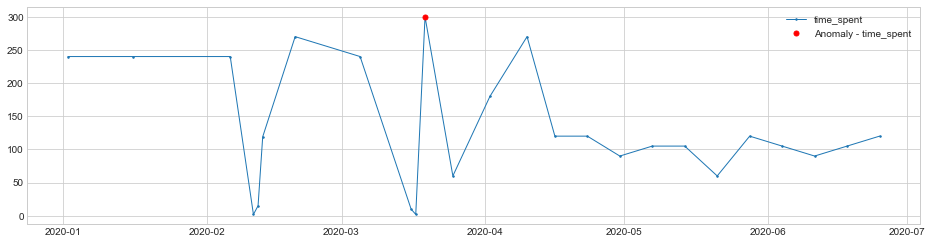

In [132]:
#Can be used to analyze any member
analyze_member(19979)

The procedure is the same as the above function. Some of the care Extender Ids you can check out (those are the ids that provided most services among the three groups

1. 77
2. 132
3. 109

In [133]:
def analyze_care_extender(care_extender_id):
    care_data = data[data['care_extender_id'] == care_extender_id][['service_date', 'time_spent']]
    care_data['service_date'] = pd.to_datetime(care_data['service_date'], format='%Y-%m-%d')
    care_data.set_index('service_date', inplace = True)
    
    s = validate_series(care_data)
    
    quantile_ad = QuantileAD(high=0.95, low=0.01)
    anomalies = quantile_ad.fit_detect(s)
    
    plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
    

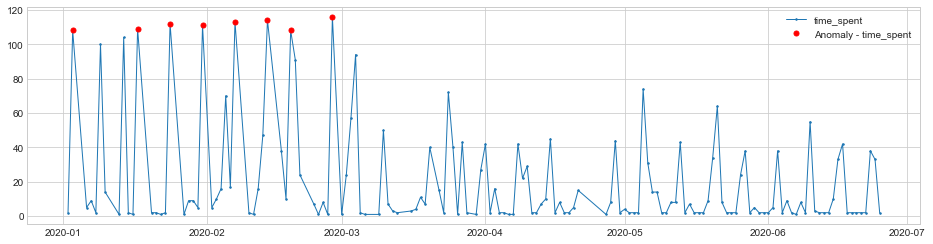

In [134]:
# Can be used to analyze any care extender
analyze_care_extender(77)

### Type 2a - Average time spent by each member per week

Here I have sorted the data weekly and got the average time spent by each member per week. Then I created a function that takes member id as input and counts the how many times they have spent same number of mins for the given 26 weeks. This function returns the member id and the counts of their average time as a list. I computed the total number of weeks they have had same mins average for by taking the max of counts. So, I kind of just assumed that anyone who has had same average mins for more than 10 weeks is like a "red flag".

In [135]:
average_per_week = data.groupby(['member_id', 'week_no'])['time_spent'].mean().reset_index().sort_values('time_spent', ascending = False)
print("Total number of entries weekly: {}".format(len(average_per_week)))
average_per_week.head()

Total number of entries weekly: 82978


,member_id,week_no,time_spent
59585,19979,15,270.0
59886,20092,11,262.5
59578,19979,6,240.0
59577,19979,3,240.0
59581,19979,10,240.0


In [136]:
def weekly_anomaly(member_id):
    member_data = average_per_week[average_per_week['member_id'] == member_id]
    counts = list(member_data['time_spent'].value_counts())
    return [member_id, counts]

In [137]:
ids = average_per_week['member_id'].apply(lambda x: weekly_anomaly(x))

In [138]:
print("The first value of the column is the member id and the second value which is the list has the counts of their average week")
s = ids.to_frame()
s.head()

The first value of the column is the member id and the second value which is the list has the counts of their average week


,member_id
59585,"[19979, [4, 4, 4, 2, 2, 1, 1, 1, 1, 1]]"
59886,"[20092, [3, 1, 1]]"
59578,"[19979, [4, 4, 4, 2, 2, 1, 1, 1, 1, 1]]"
59577,"[19979, [4, 4, 4, 2, 2, 1, 1, 1, 1, 1]]"
59581,"[19979, [4, 4, 4, 2, 2, 1, 1, 1, 1, 1]]"


In [139]:
new_col_list = ['members_id', 'counts' ]
for n,col in enumerate(new_col_list):
    s[col] = s['member_id'].apply(lambda x: x[n])
    
s = s.drop('member_id',axis=1)

In [140]:
s = s[s['counts'].apply(len) > 0]

In [141]:
s['max_count'] = s['counts'].apply(lambda x: max(x))
s = s[s['max_count'] > 8]
s = s.drop('counts',axis=1)

In [142]:
s = s.drop_duplicates('members_id')
s= s.sort_values('max_count', ascending=False)

In [143]:
print("Total number of Ids that are flagged: {}".format(len(s)))
print("Column A: Members Id \nColumn B: Same average mins for given no. of weeks")
s.head()

Total number of Ids that are flagged: 692
Column A: Members Id 
Column B: Same average mins for given no. of weeks


,members_id,max_count
9283,3488,23
36462,14294,23
5369,2866,22
37664,14460,21
26014,9406,21
